# Import libraries

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, multivariate_normal
from sklearn.linear_model import LinearRegression
import corner
import pylab

%matplotlib inline

# Functions

In [2]:
def positive_gauss(mean, std):
    rndnum = 0
    while rndnum <= 0:
        rndnum = random.gauss(mean, std)
    return rndnum

In [3]:
def dist_trunc(mean,std,n):
    x_dist = truncnorm(a=-mean/std, b=np.inf,loc=mean,scale=std)
    return (x_dist.rvs(n)).astype(float)

In [4]:
def dist_trunc_dep(meana,stda,meanb,stdb,covar,n):
    ref_matrix=np.array([[stda**2,covar],[covar,stdb**2]])
    ref_sample=multivariate_normal.rvs(mean=(meana,meanb),cov=ref_matrix, size=3*n)
    ref_sample = ref_sample[ref_sample[:,1] > 0]
    return ref_sample

In [5]:
def find_q_sk(d,i):
    x=list()
    y=list()
    
    for k,v in d.items():
        for m,n in v.items():
            if m>0:
                y.append(d[k][m]['alpha'][i] /  d[k][0]['ref_alpha_dep'][i] -1)
                x.append(d[k][m]['LET']*d[k][0]['ref_beta_dep'][i]/d[k][0]['ref_alpha_dep'][i])
             
    x= np.asarray(x).reshape(-1,1)
    reg = LinearRegression(fit_intercept=False).fit(x, y)
    q=reg.coef_[0]
    if q<-1 :
        print(k,m,i)
    R=reg.score(x,y)
    return q,R

In [6]:
def plot_style():
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='major', linestyle=':', linewidth='0.2', color='k')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='k')

    plt.rcParams['xtick.direction'] = 'in' 
    plt.rcParams['ytick.direction'] = 'in' 
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = True  
    plt.rc('font', size='20')  
    
    params = {'legend.fontsize': '20',
         'figure.figsize': (10,6),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
    pylab.rcParams.update(params)

# Open data 

In [7]:
fname = os.path.join('tmp','fitted_data.h5')
df = pd.read_hdf(fname, 'data')

# Define new variables

In [8]:
df.rename(columns = {"a(fit)/b(fit)": "alpha(fit)/beta(fit)", "alfa_fit":"alpha_fit","alfa_fit_err":"alpha_fit_err"},inplace=True)

In [9]:
df2 = df.groupby(["article",'energy']).max()
df2.is_copy=False

\begin{align}
\frac{\alpha}{\alpha_{phot}} = 1+ \frac{q L}{(\frac{\alpha}{\beta})_{phot}}
\end{align}

In [10]:
for name, group in df2.groupby('article'):
        for energy, data in group.groupby('energy'):
            if energy ==0:
                ab_ref=data["alpha(fit)/beta(fit)"].unique()                
                a_ref=data["alpha_fit"].unique()
                a_ref_err=data["alpha_fit_err"].unique()
                b_ref=data["beta_fit"].unique()
                b_ref_err=data["beta_fit_err"].unique()
                covar_ref= data["covar_fit"].unique()
                
                df2.loc[(name,energy),'a_fit_ref'] = a_ref
                df2.loc[(name,energy),'a_fit_ref_err'] = a_ref_err
                df2.loc[(name,energy),'b_fit_ref'] = b_ref
                df2.loc[(name,energy),'b_fit_ref_err'] = b_ref_err
                df2.loc[(name,energy),'covar_ref'] = covar_ref
            
            else:
                a=data["alpha_fit"].unique()
                a_err=data["alpha_fit_err"].unique()
                
                aa_ref=data['a(fit)/a_ref(fit)'].unique()
                aa_ref_art=data['a/a_ref'].unique()
                L=(data["LET"]).unique()
                
               
                q = (aa_ref-1.0)*ab_ref/L
                k=(aa_ref-1.0)/L

                
                error=  np.sqrt(np.power((1-a_ref)/b_ref*a_err,2)+
                                np.power((a-1)/b_ref*a_ref_err,2)+
                                np.power((a_ref-a)/np.power(b_ref,2)*b_ref_err,2))

                df2.loc[(name,energy),'q'] = q
                df2.loc[(name,energy),'k'] = k
                df2.loc[(name,energy), "error"] = error

<ipython-input-10-b87b106cf55c>:30: RuntimeWarning: divide by zero encountered in true_divide
  error=  np.sqrt(np.power((1-a_ref)/b_ref*a_err,2)+
<ipython-input-10-b87b106cf55c>:31: RuntimeWarning: divide by zero encountered in true_divide
  np.power((a-1)/b_ref*a_ref_err,2)+
<ipython-input-10-b87b106cf55c>:32: RuntimeWarning: divide by zero encountered in true_divide
  np.power((a_ref-a)/np.power(b_ref,2)*b_ref_err,2))


In [11]:
for name, group in df2.groupby('article'):
        for energy, data in group.groupby('energy'):
            df2.loc[(name, energy),"ab_ref"]=df2.loc[(name,0), "alpha(fit)/beta(fit)"]

In [12]:
df2 = df2.replace([np.inf, -np.inf, np.NaN], 0)
df2.isnull().sum().sum()

0

# Draw alpha & beta

In [13]:
num=100000

In [14]:
d ={}

In [15]:
for name, group in df2.groupby('article'):
    d[name]={}
    for energy, data in group.groupby('energy'):
      
        if energy == 0:
            d[name][0] = {}
            d[name][0][ 'ref_alpha'] = dist_trunc(data.a_fit_ref.values, 
                                                  data.a_fit_ref_err.values, num)
            d[name][0][ 'ref_beta'] = dist_trunc(data.b_fit_ref.values, 
                                                 data.b_fit_ref_err.values, num)
            ref_sample = np.array(dist_trunc_dep(data.a_fit_ref.values.max(),
                                                 data.a_fit_ref_err.values.max(),
                                                 data.b_fit_ref.values.max(),
                                                 data.b_fit_ref_err.values,
                                                 data.covar_fit,num))
            d[name][0][ 'ref_alpha_dep']=ref_sample[:,0]
            d[name][0][ 'ref_beta_dep']=ref_sample[:,1]

        else:
            d[name][energy]={}
            d[name][energy][ 'alpha'] = dist_trunc(data.alpha_fit.values, 
                                                   data.alpha_fit_err.values, num)
            d[name][energy][ 'beta'] = dist_trunc(data.beta_fit.values, 
                                                  data.beta_fit_err.values, 
                                                  num)
            ref_sample = np.array(dist_trunc_dep(data.alpha_fit.values.max(),
                                                 data.alpha_fit_err.values.max(),
                                                 data.beta_fit.values.max(),
                                                 data.beta_fit_err.values,data.covar_fit,num))
            d[name][energy][ 'alpha_dep']=ref_sample[:,0]
            d[name][energy][ 'beta_dep']=ref_sample[:,1]
            d[name][energy]['LET']=data.LET.values.max()
    

<ipython-input-4-209f00e36413>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ref_matrix=np.array([[stda**2,covar],[covar,stdb**2]])


# Alpha & Beta distributions

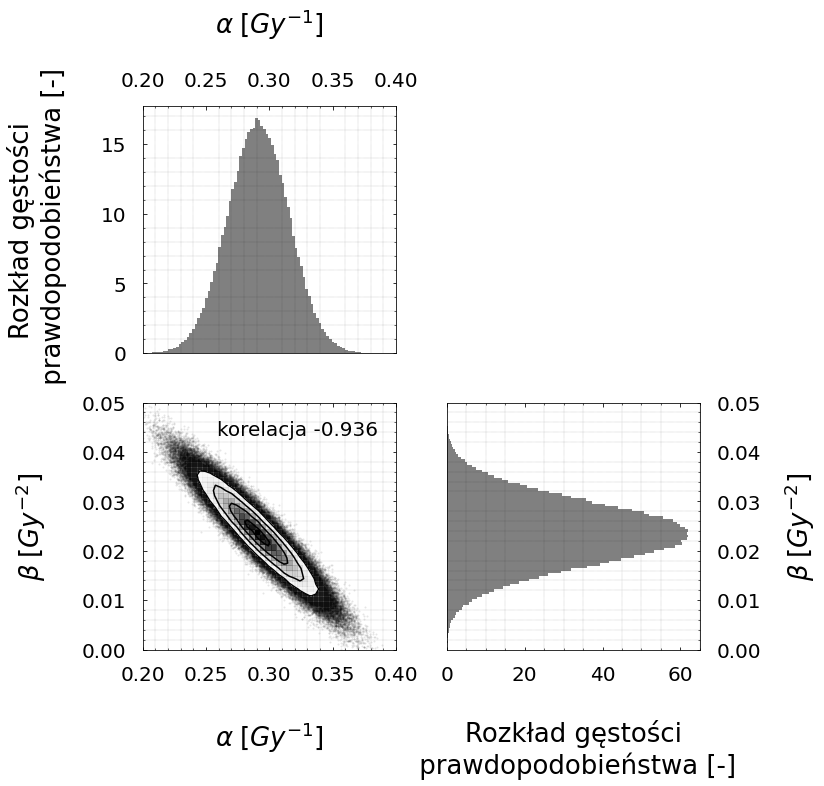

In [24]:
a = d['10'][5010]['alpha_dep']
b=(d['10'][5010]['beta_dep'])

fig, ax = plt.subplots(2,2, figsize=(10,10))

# plot 1D histograms
ax[0][0].hist(a, bins=100, density=True,color='gray')
ax[0][0].set_xlim(0.2,0.4)

ax[1][1].hist(b, bins=100, density=True, orientation='horizontal',color='gray')
ax[1][1].set_ylim(0.,0.05)


ax[0][0].set_title(r'$\alpha\; [Gy^{-1}]$'+'\n')
ax[0][0].xaxis.set_ticks_position('top')
ax[0][0].set_ylabel('Rozkład gęstości\n prawdopodobieństwa [-]\n')

ax[1][1].set_ylabel('\n'+r'$\beta\; [Gy^{-2}]$')
ax[1][1].set_xlabel('\nRozkład gęstości\n prawdopodobieństwa [-]')
ax[1][1].yaxis.set_label_coords(1.2, 0.5)

ax[1][1].yaxis.tick_right()
ax[1][1].yaxis.set_label_position("right")

# plot 2D histogram
corner.hist2d(x=a, y=b, bins=50, ax=ax[1][0])
ax[1][0].set_xlabel('\n'+r'$\alpha \;[Gy^{-1}]$')
ax[1][0].set_ylabel(r'$\beta \;[Gy^{-2}]$'+'\n')

ax[1][0].set_xlim(0.2,0.4)
ax[1][0].set_ylim(0.,0.05)


# common settings
for axx in ax.flatten():
    axx.grid()
    axx.minorticks_on()
    axx.grid(which='major', linestyle=':', linewidth='0.2', color='k')
    axx.grid(which='minor', linestyle=':', linewidth='0.2', color='k')

ax[0][1].set_visible(False)

ax[1][0].legend( ['korelacja -0.936'],
          loc='upper right', frameon=False)


#plot setup
plt.rcParams['xtick.direction'] = 'in' 
plt.rcParams['ytick.direction'] = 'in' 
plt.rcParams['xtick.top'] = True 
plt.rcParams['ytick.right'] = True  
plt.rc('font', size='20')  
    
params = {'legend.fontsize': '20',
         'figure.figsize': (10,6),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
pylab.rcParams.update(params)

tmp=pd.DataFrame(list(zip(a,b)),
                          columns=['alpha','beta'])
tmp.to_csv("results/figure_5_2")

plt.savefig(fname="results/figure_5_2",dpi= 700)

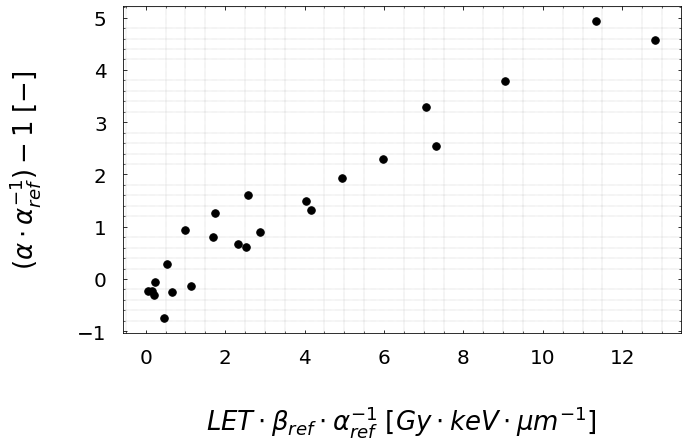

In [30]:
x=list()
y=list()
i=0    
for k,v in d.items():

    for m,n in v.items():
        if m>0:
            #print(i,k,m)
            y.append(d[k][m]['alpha'][i] /  d[k][0]['ref_alpha_dep'][i]-1)
            x.append(d[k][m]['LET']*d[k][0]['ref_beta_dep'][i]/d[k][0]['ref_alpha_dep'][i])
    
plt.plot(x,y, ".",c='black',markersize=15)

plot_style()
    
plt.xlabel('\n'+r'$LET \cdot \beta_{ref}\cdot \alpha^{-1}_{ref} \;[Gy\cdot  keV  \cdot\mu m^{-1}]$')
plt.ylabel(r'$(\alpha \cdot \alpha^{-1}_{ref})-1 \;[-]$'+'\n')

tmp=pd.DataFrame(list(zip(x,y)),
                          columns=['data_x','data_y'])
tmp.to_csv("results/figure_5_4")

plt.savefig(fname="results/figure_5_4",dpi= 700)

# Q-distribution

In [26]:
qtmp,Rtmp=zip(*[find_q_sk(d,i) for i in range(num)])    

In [27]:
R=pd.DataFrame(np.asarray(Rtmp))
qdf=pd.DataFrame(np.asarray(qtmp))
qdf.columns = ['q']

In [28]:
qdf.q.mean(), qdf.q.std(), qdf.q.median(), qdf.q.quantile(0.025),qdf.q.quantile(0.975)

(0.376717160899258,
 0.031953233197340856,
 0.3800807193338547,
 0.29788933443274057,
 0.43087326065971615)

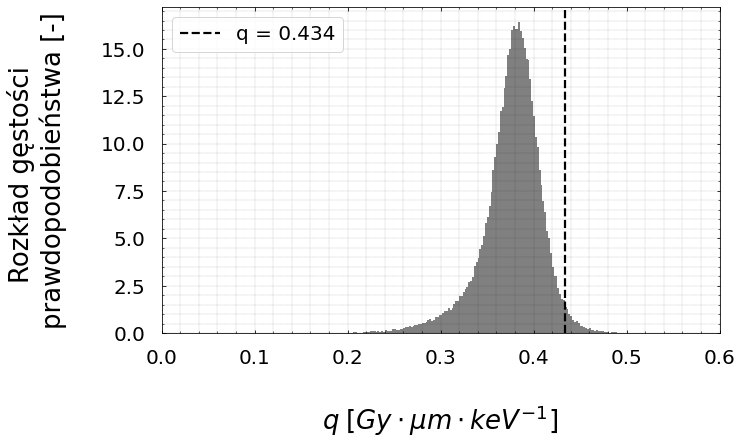

In [31]:
qdf.q.hist(bins=(200), density=True,color='grey')
plt.axvline(x=0.434, label='q = 0.434'.format(0.434),c='k',ls='--',lw=2.2)
plot_style()

plt.xlim(0,0.6)
plt.xlabel('\n'+r'$q\; [Gy\cdot \mu m \cdot keV^{-1}]$')
plt.ylabel("Rozkład gęstości \nprawdopodobieństwa [-]\n")
plt.legend()

tmp=pd.DataFrame(list(zip(qdf.q)),
                          columns=['q'])
tmp.to_csv("results/figure_5_7")

plt.savefig(fname="results/figure_5_7",dpi= 700)

# Save temporary files


In [22]:
hdf_fname = os.path.join('tmp','distrib_q.h5')
qdf.to_hdf(hdf_fname, 'q', format='table')